<a href="https://colab.research.google.com/github/nisarahamedk/kaggle-riid/blob/master/notebooks/riid-pytorch-transformers_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%%capture
!pip install gcsfs

In [68]:
import math

import gcsfs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Read the dataset

In [69]:
# DATA_PATH = "/kaggle/input/riiid-test-answer-prediction/"
DATA_PATH = "gs://kds-e80dfc3d272252bbf34c627d756f891826dab0c19f30ec0fc3ac1979"

In [70]:
dtypes_train = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
    }

dtypes_questions = {
    "question_id": "",
    "bundle_id": "",
    "correct_answer": "",
    "part": "",
    "tags": "",
}

dtypes_lectures = {
    "lecture_id": "",
    "part": "",
    "tag": "",
    "type_of": "",
}

In [71]:
train_df = pd.read_csv(DATA_PATH + "/train.csv", dtype=dtypes_train, nrows=1e6)
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [72]:
questions_df = pd.read_csv(DATA_PATH + "/questions.csv")
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [73]:
lectures_df = pd.read_csv(DATA_PATH + "/lectures.csv")
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [74]:
# removing lecture rows.
train_df = train_df[train_df.answered_correctly != -1]

In [75]:
train_df = train_df.join(questions_df, on="content_id")
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5692,3,5,151
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716,5716,2,5,168
2,2,118363,115,128,0,0,0,1,55000.0,False,128,128,0,1,131 149 92
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860,7860,0,1,131 104 81
4,4,137965,115,7922,0,4,1,1,11000.0,False,7922,7922,1,1,131 149 92


In [76]:
drop_cols = [
             "row_id", 
             "timestamp", 
             "content_type_id", 
             "user_answer", 
             "prior_question_had_explanation", 
             "question_id", 
             "bundle_id", 
             "correct_answer", 
             "tags"
             ]
train_df = train_df.drop(drop_cols, axis=1)
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5692,1,1,NaN,5
1,115,5716,2,1,37000.0,5
2,115,128,0,1,55000.0,1
3,115,7860,3,1,19000.0,1
4,115,7922,4,1,11000.0,1


In [77]:
# 0 is used for padding, so increment 1
indicator_cols = ["content_id", "task_container_id", "part"]
for c in indicator_cols:
  train_df[c] = train_df[c] + 1
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,NaN,6
1,115,5717,3,1,37000.0,6
2,115,129,1,1,55000.0,2
3,115,7861,4,1,19000.0,2
4,115,7923,5,1,11000.0,2


In [78]:
# convert milliseconds to minutes.
train_df['prior_question_elapsed_time'] = train_df["prior_question_elapsed_time"].fillna(0).astype(np.float32) / 60000
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,0.000000,6
1,115,5717,3,1,0.616667,6
2,115,129,1,1,0.916667,2
3,115,7861,4,1,0.316667,2
4,115,7923,5,1,0.183333,2


In [79]:
user_groups = train_df.groupby("user_id")
len(user_groups)

3824

### Pytorch Iterable Dataset

In [80]:
# just some stuff I ctrl C ctrl V from StackOverflow (with little changes)
# [1,2,3,4] --- w = 2 --[[1,2], [2,3], [3,4]] but 2D to 3D
def rolling_window(a, w):
    s0, s1 = a.strides
    m, n = a.shape
    return np.lib.stride_tricks.as_strided(
        a, 
        shape=(m-w+1, w, n), 
        strides=(s0, s0, s1)
    )

def make_timeseries(x, window_length):
  """
  x - shape (seq_len, features)
  """
  # pad a lot of 0s before so when we create windows, we will have appropriate padding.
  x = np.pad(x, ((window_length-1, 0), (0, 0)), constant_values=0) # add padding to the first dimension
  
  # roll windows 
  x = rolling_window(x, window_length) # shape will become - (seq_len, window_length, features)

  return x

def add_features_to_user_df(user_df):

  # shifted answered_correctly, SOS 3
  user_df["answered_correctly"] = user_df["answered_correctly"].shift(fill_value=2) + 1

  return user_df

class RiidDataset(IterableDataset):
  def __init__(self, user_groups, window_length=128, batch_size=32, n_batches=None):
    super().__init__()
    self.user_groups = user_groups
    self.window_length = window_length
    self.batch_size = batch_size
    self.__len = None
    self.n_batches = n_batches
    if n_batches:
      self.__len = n_batches

  def __len__(self):
    if not self.__len:
      b = 0
      for xb, yb in self:
        b += 1
      self.__len = b
    return self.__len 

  def __iter__(self):
    b = 0
    for user_id, user_df in self.user_groups:
      user_df = user_df.drop(columns="user_id")
      y = user_df["answered_correctly"].to_numpy().copy()
      x = add_features_to_user_df(user_df)

      x = make_timeseries(x, self.window_length)
      x = np.transpose(x, (1, 0, 2)) # reshape to [seq_length, bs, features]
      # y = make_timeseries(np.expand_dims(y, axis=1), self.window_length)
      for i in range(0, x.shape[1], self.batch_size):
          start, end = i, i+self.batch_size
          if end > x.shape[1]: # ignoring last incomplete batches, this ignores users with interaction < batchsize, FIX THIS
                continue
          if self.n_batches and b == self.n_batches:
            raise StopIteration
          yield x[:, start:end, :], y[start:end]
          b += 1

In [81]:
riid_ds = RiidDataset(user_groups, window_length=128, batch_size=128, n_batches=1)

In [82]:
train_dl = DataLoader(riid_ds)
x, y = next(iter(train_dl))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([1, 128, 128, 5]), torch.Size([1, 128]), torch.float64, torch.int8)

In [83]:
y

tensor([[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0]], dtype=torch.int8)

In [84]:
len(train_dl)

1

In [85]:
batches = 0
max_batch_size = 0
max_seq_len = 0
for xb, yb in train_dl:
    max_batch_size = max(max_batch_size, xb.size(2))
    max_seq_len = max(max_seq_len, xb.size(1))
    batches += 1
    
max_batch_size, max_seq_len, batches

(128, 128, 1)

##### Padding mask

In [86]:
pad_mask = torch.all(torch.eq(x.squeeze(0), 0), dim=-1).T
pad_mask.shape

torch.Size([128, 128])

### Transformer Sequence Classifier.

Positional Encoding

In [87]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [149]:
class TransformerClassifier(nn.Module):
    
    def __init__(self, n_tokens_dict, d_model=512, n_heads=8, hidden_dim=1024, n_layers=1, dropout=0):
        
        super().__init__()
        self.d_model = d_model
        
        # Transformer encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, hidden_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Input embeddings for content_id, task_container_id, answered_correctly, prior_question_elapsed_time, part
        self.content_id_emb = nn.Embedding(n_tokens_dict["content_id"], d_model)
        self.task_container_id_emb = nn.Embedding(n_tokens_dict["task_container_id"], d_model)
        self.answered_correctly_emb = nn.Embedding(n_tokens_dict["answered_correctly"], d_model)
        self.part_emb = nn.Embedding(n_tokens_dict["part"], d_model)
        # self.prior_question_elapsed_time_emb = nn.Linear(1, d_model, bias=False)
        # Positional Encoding
        self.pos_enc = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.out = nn.Linear(d_model, 1)
        
    def forward(self, x):
        
        x = x.squeeze(0) # TODO: take care of this in data loader, extra batch dim incase of IterableDataset [seq_len, bs, d_model]

        # padding mask
        src_key_padding_mask =  torch.all(torch.eq(x.squeeze(0), 0), dim=-1).T # shape [bs, seq_len]
        
        # input embedding
        content_id_emb = self.content_id_emb(x[..., 0].long())
        task_container_id_emb = self.task_container_id_emb(x[..., 1].long())
        answered_correctly_emb = self.answered_correctly_emb(x[..., 2].long())
        part_emb = self.part_emb(x[..., 4].long())
        # prior_question_elapsed_time_emb = self.prior_question_elapsed_time_emb(x[..., 3].unsqueeze(-1).float())
        
        # shape [seq_len, bs, d_model]
        input_emb = (content_id_emb 
                     + task_container_id_emb
                     + answered_correctly_emb
                     + part_emb
                     # + prior_question_elapsed_time_emb
                     )
        input_emb = input_emb * math.sqrt(self.d_model) # needed?

        input_emb = self.pos_enc(input_emb) # position encoding
        
        # transformer blocks
        z = self.transformer_encoder(input_emb, src_key_padding_mask=src_key_padding_mask) # shape [seq_len, bs, d_model]
        
        # global average pooling over the sequence length dimension
        x = z.mean(dim=0) # shape [bs, d_model]
        
        # output layer
        out = self.out(x) # shape [bs, 1]
        
        return torch.sigmoid(out), z, x
        


In [89]:
n_tokens_dict = {
    "content_id": max(train_df["content_id"]) + 1,
    "task_container_id": max(train_df["task_container_id"]) + 1,
    "answered_correctly": 4, # 0-padding, 1-incorrect, 2-correct, 3-fill value
    "part": max(train_df["part"]) + 1
}

n_tokens_dict

{'answered_correctly': 4,
 'content_id': 13524,
 'part': 9,
 'task_container_id': 7741}

In [90]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [91]:
model = TransformerClassifier(n_tokens_dict, n_layers=3).to(device)
model

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
     

### Training

In [92]:
epochs = 1
opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=epochs)
loss_func = nn.BCELoss()

https://pytorch.org/tutorials/beginner/nn_tutorial.html#create-fit-and-get-data

##### Visualize Gradients

In [135]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [94]:
def loss_batch(model, loss_func, X_batch, y_batch, opt=None):

  preds = model(X_batch)
  loss = loss_func(preds, y_batch)

  if opt is not None:
    loss.backward()
    plot_grad_flow(model.named_parameters())
    # nn.utils.clip_grad_norm_(model.parameters(), 0.25)
    opt.step()
    opt.zero_grad()

  return loss.item(), X_batch.shape[2]

In [95]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl=None, sched=None):
  epoch_losses = []
  epoch_lrs = []
  for e in range(epochs):
    # train
    lrs = []
    train_losses = []
    val_losses = []

    model.train()
    train_dl = tqdm(train_dl, position=0, leave=True)
    for X_batch, y_batch in train_dl:
      X_batch, y_batch = X_batch.to(device), y_batch.T.type(torch.FloatTensor).to(device)
      train_loss, train_bs = loss_batch(model, loss_func, X_batch, y_batch, opt)
      train_losses.append(train_loss)
      train_loss_mean = sum(train_losses) / len(train_losses)
      lr = opt.param_groups[0]["lr"]
      lrs.append(lr)
      train_dl.set_description(f"Epoch: {e}, RunningLoss: {train_loss_mean:.3f}, InstantLoss: {train_loss:.3f}, LR: {lr:.6f}")
      if sched:
        sched.step()
    epoch_losses.append(train_loss_mean)
    epoch_lrs.append(lr)
    # eval
    # model.eval()
    # with torch.no_grad():
    #   val_losses, val_bss = zip(*[loss_batch(model, loss_func, X_batch, y_batch) for X_batch, y_batch in valid_dl])

    # val_loss = np.sum(np.multiply(val_losses, val_bss)) / np.sum(val_bss)
    # train_dl.set_description(f"Epoch: {e}, Loss: {train_loss}, Val Loss: {val_loss}")

  return epoch_losses, epoch_lrs#, val_losses

In [96]:
# train_losses, lrs = fit(epochs, model, loss_func, opt, train_dl, sched=sched)

### Use backprop to chart dependencies

http://karpathy.github.io/2019/04/25/recipe/

In [97]:
ds = RiidDataset(user_groups, window_length=128, batch_size=128, n_batches=1)
train_dl = DataLoader(ds)

one batch

In [98]:
# first batch,
X_batch, y_batch = next(iter(train_dl))
X_batch = X_batch.to("cuda")
y_batch = y_batch.T.float().to("cuda")
X_batch.requires_grad = True

In [99]:
model = TransformerClassifier(n_tokens_dict, n_layers=3).to("cuda")
model.eval() # no funny business by batchnorm
out = model(X_batch)

Loss functions on selected samples from the batch.  

Apply loss function on selected samples of the batch only.

In [100]:
loss = loss_func(out[:5], y_batch[0:5]) 
loss.backward() 

Make sure the gradients are calculated to related samples only.

Here we have look at the content_id input embedding.  Whatever "content_id"s were there in the samples that we used in the loss function. Only its gradients should be non-zero. Everything else should Zero.

In [101]:
for n, p in model.named_parameters():
  if n == "content_id_emb.weight":
    print("Gradients of Content Embedding..")
    # Expected non-zero gradient check
    print((p.grad[5693] != 0).all(), (p.grad[0] != 0).all())
    # All other gradients 0 check
    print((p.grad[5145] == 0).all())

Gradients of Content Embedding..
tensor(False, device='cuda:0') tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


#### Analysing the gradients 

In [167]:
ds = RiidDataset(user_groups, window_length=128, batch_size=128, n_batches=1)
train_dl = DataLoader(ds)

In [168]:
# first batch,
X_batch, y_batch = next(iter(train_dl))
X_batch = X_batch.to("cuda")
y_batch = y_batch.T.float().to("cuda")
X_batch.requires_grad = True

In [171]:
model = TransformerClassifier(n_tokens_dict, n_layers=1).to("cuda")
model.eval() # no funny business by batchnorm
out, _, _ = model(X_batch)

In [172]:
loss = loss_func(out, y_batch)
loss.backward()

In [178]:
[(n, p.shape) for n, p in model.named_parameters()]

[('transformer_encoder.layers.0.self_attn.in_proj_weight',
  torch.Size([1536, 512])),
 ('transformer_encoder.layers.0.self_attn.in_proj_bias', torch.Size([1536])),
 ('transformer_encoder.layers.0.self_attn.out_proj.weight',
  torch.Size([512, 512])),
 ('transformer_encoder.layers.0.self_attn.out_proj.bias', torch.Size([512])),
 ('transformer_encoder.layers.0.linear1.weight', torch.Size([1024, 512])),
 ('transformer_encoder.layers.0.linear1.bias', torch.Size([1024])),
 ('transformer_encoder.layers.0.linear2.weight', torch.Size([512, 1024])),
 ('transformer_encoder.layers.0.linear2.bias', torch.Size([512])),
 ('transformer_encoder.layers.0.norm1.weight', torch.Size([512])),
 ('transformer_encoder.layers.0.norm1.bias', torch.Size([512])),
 ('transformer_encoder.layers.0.norm2.weight', torch.Size([512])),
 ('transformer_encoder.layers.0.norm2.bias', torch.Size([512])),
 ('content_id_emb.weight', torch.Size([13524, 512])),
 ('task_container_id_emb.weight', torch.Size([7741, 512])),
 ('answ

Weights shape: torch.Size([13524, 512])
Grads shape: torch.Size([13524, 512])


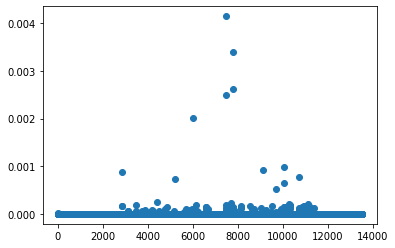

In [143]:
for n, p in model.named_parameters():
  if n == "content_id_emb.weight":
    print(f"Weights shape: {p.shape}")
    print(f"Grads shape: {p.grad.shape}")
    plt.scatter(np.arange(p.shape[0]), np.max(p.grad.cpu().numpy(), axis=-1))

(array([ 1.,  0., 11., 20., 14., 36., 46., 22., 30., 76.]),
 array([    0. ,  1138.7,  2277.4,  3416.1,  4554.8,  5693.5,  6832.2,
         7970.9,  9109.6, 10248.3, 11387. ]),
 <a list of 10 Patch objects>)

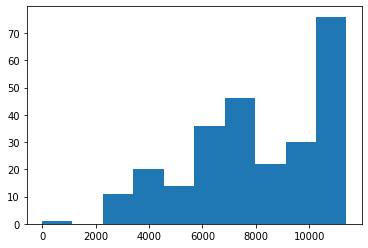

In [144]:
plt.hist(X_batch[0, :, :, 0].detach().flatten().cpu().numpy())

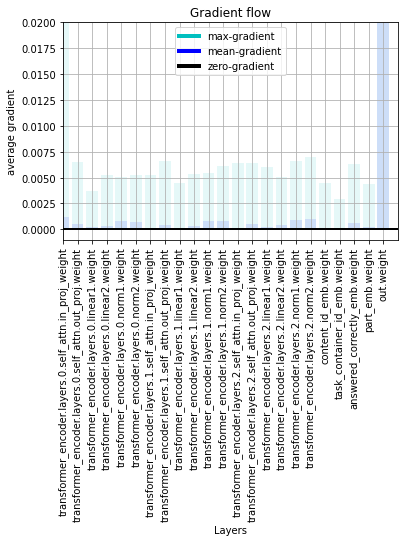

In [145]:
plot_grad_flow(model.named_parameters())

#### Analyse the attention_out, average pooled 

In [159]:
ds = RiidDataset(user_groups, window_length=128, batch_size=128, n_batches=1)
train_dl = DataLoader(ds)

In [154]:
# first batch,
X_batch, y_batch = next(iter(train_dl))
X_batch = X_batch.to("cuda")
y_batch = y_batch.T.float().to("cuda")
X_batch.requires_grad = True

In [156]:
model = TransformerClassifier(n_tokens_dict, n_layers=3).to("cuda")
model.eval() # no funny business by batchnorm
out, z, x = model(X_batch)

In [157]:
loss = loss_func(out, y_batch)
loss.backward()

1st sample in the batch, only one actual value, rest padding

In [162]:
X_batch[0, :, 0, :]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00,

attention weights out of the transformer block for the same sample

In [166]:
z.shape # [seq_len, bs, d_model]

torch.Size([128, 128, 512])

In [163]:
z[:, 0, :]

tensor([[-0.0190, -2.4010,  0.9633,  ..., -1.3397, -0.4058,  0.0787],
        [-0.0106, -2.4059,  0.9735,  ..., -1.3386, -0.4048,  0.0738],
        [-0.0107, -2.4173,  0.9755,  ..., -1.3370, -0.4046,  0.0693],
        ...,
        [-0.0285, -2.3969,  0.9831,  ..., -1.3289, -0.4059,  0.0761],
        [-0.0183, -2.3951,  0.9820,  ..., -1.3318, -0.4072,  0.0781],
        [-0.3994, -1.6760,  0.2884,  ..., -0.9493, -0.9806,  0.8486]],
       device='cuda:0', grad_fn=<SliceBackward>)

Can see the entries related to padding is almost same, last entry which is not related to padding is not similar to others.

In [165]:
# after mean along the sequenece length dimension.
x[0]

tensor([-0.0189, -2.4040,  0.9679, -0.0350,  0.4952, -1.6525,  0.5435, -0.1691,
         0.4613,  0.2164,  1.6368,  0.2750,  0.2757,  0.7277,  0.4760,  1.2814,
         0.1719,  1.0767, -0.1907,  0.4551,  0.2880, -0.6537,  0.3241,  1.3923,
        -0.3880, -1.6962,  0.0382, -0.7025,  0.4383, -1.3771, -0.6230,  0.5817,
         0.2453, -0.2776,  2.1425,  0.1954,  1.2895, -0.0593, -0.0518, -0.9305,
         0.0254, -1.0057,  0.0070, -1.5264, -0.9188,  0.6451, -0.4710, -0.6332,
        -0.3552, -0.8311,  0.2607,  0.6189,  0.4720, -1.0215, -1.5067, -1.1918,
        -1.4424, -0.0070,  0.3924, -0.4579, -0.3115, -1.8197,  0.1835, -0.1936,
        -2.6158, -0.4601,  0.1834,  0.9361, -1.3380,  0.7204,  1.1145, -0.5667,
         0.6860, -1.7876, -0.3718,  0.7238, -0.3050, -0.6029,  1.1652, -1.0187,
         0.1036,  0.0335, -0.3910, -0.2849, -0.1566, -0.6023, -0.1741, -2.1455,
        -1.0389,  0.2792,  0.7043, -1.1819,  0.2096, -0.0155, -0.1493,  1.4389,
         0.8742,  0.9708,  0.8520,  1.64